Credit to https://github.com/harvitronix/neural-network-genetic-algorithm 

In [ ]:
from keras.datasets import mnist,cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import regularizers
from keras.utils import np_utils



Using TensorFlow backend.


In [ ]:
def compute_mag_phase(toBeTransfromed):
    dft = np.fft.fft2(toBeTransfromed)
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    ang = np.angle(dft_shift)
    return mag, ang

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined

def pre_process_mag(dataset):
    mag = np.zeros(dataset.shape)
    phase = np.zeros(dataset.shape)
    x= 0
    for i in range(0,dataset.shape[0]):
      mag[i,:,:],phase[i,:,:] = compute_mag_phase(dataset[i])
    return mag,phase


def reconstructAll(mag, ang):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag[i,:,:],ang[i,:,:])
    return recon

In [ ]:
# the data, shuffled and split between train and val sets
# Here we are using the official test set as our validation set, in further
# tutorials, test and validation splits will be explained properly.
(x1_train, y1_train), (x1_test, y1_test) = cifar10.load_data()

print('Image shape: {0}'.format(x1_train.shape[1:]))
print('Total number of training samples: {0}'.format(x1_train.shape[0]))
print('Total number of test samples: {0}'.format(x1_test.shape[0]))

x1_train = x1_train.astype('float32')
x1_test = x1_test.astype('float32')

# Normalize the image
x1_train /= 255
x1_test /= 255

print(x1_train.shape)

y1_train_class = np_utils.to_categorical(y1_train, 10)
y1_test_class = np_utils.to_categorical(y1_test, 10)

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of test samples: 10000
(50000, 32, 32, 3)


In [ ]:
import random
import numpy as np
np.random.seed(100)
noise_mag = np.random.uniform(size = (32,32,3),low = 0.0, high = 7.0)

const_mag = np.full((32, 32, 3), 1.2)

In [ ]:
def reconstructPhase(mag, ang):
    recon = np.zeros(ang.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag,ang[i,:,:])
    return recon

In [ ]:
dc, x_train_phase = pre_process_mag(x1_train)
del dc
dc, x_test_phase = pre_process_mag(x1_test)
del dc
x_train_recon_phase = reconstructPhase(const_mag,  x_train_phase)
del x_train_phase
x_test_recon_phase = reconstructPhase(const_mag,  x_test_phase)
del x_test_phase

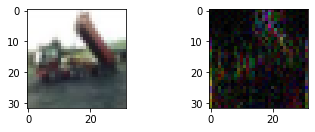

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(221)
plt.imshow(x1_train[2])
plt.subplot(222)
plt.imshow(x_train_recon_phase[2])

In [ ]:
del x1_train
del x1_test

In [ ]:
early_stopper = EarlyStopping(monitor='val_accuracy',patience=1)

def get_cifar_const_mag():
    # Set defaults.
    nb_classes = 10
    batch_size = 32
    input_shape = (32, 32, 3)

    # Get the data.
    x_train = x_train_recon_phase
    y_train = y1_train_class
    x_test = x_test_recon_phase
    y_test = y1_test_class

    return (nb_classes, batch_size, input_shape, x_train, x_test, y_train, y_test)


def get_cifar10():
    # Set defaults.
    nb_classes = 10
    batch_size = 32
    input_shape = (32, 32, 3)

    # Get the data.
    x_train = x1_train
    y_train = y1_train_class
    x_test = x1_test
    y_test = y1_test_class

    return (nb_classes, batch_size, input_shape, x_train, x_test, y_train, y_test)

def compile_model(network, nb_classes, input_shape):
    """Compile a sequential model.
    Args:
        network (dict): the parameters of the network
    Returns:
        a compiled network.
    """
    # Get our network parameters.
        #'VGG_layers': range(1,5),
        #VGG_sublayers': range(1,4),

    VGG_layers = network['VGG_layers']
    VGG_sublayers = network['VGG_sublayers']
    pool_num =network['pool_num']

    nb_layers = network['nb_layers']
    nb_neurons1 = network['nb_neurons1']
    nb_neurons2 = network['nb_neurons2']
    nb_neurons3 = network['nb_neurons3']
    nb_neurons4 = network['nb_neurons4']
    activation = network['activation']
    optimizer = network['optimizer']
    dropout1 = network['dropout1']
    dropout2 = network['dropout2']

    if network['optimizer'] == 'rmsprop':
      optimizer =  RMSprop(lr=0.0001, decay=1e-6)

    model = Sequential()

    if VGG_layers == 0:                        #no conv layers
      for i in range(nb_layers):

          # Need input shape for first layer.
          if i == 0:
              model.add(Flatten(input_shape=(32,32,3)))
              model.add(Dense(nb_neurons1, activation=activation))
          elif i == 1:
              model.add(Dense(nb_neurons2, activation=activation))
          elif i == 2:
              model.add(Dense(nb_neurons3, activation=activation))
          elif i == 3:
              model.add(Dense(nb_neurons4, activation=activation))

          model.add(Dropout(dropout2))  # hard-coded dropout

    else:
      for i in range(VGG_layers):
          if i == 0:
              model.add(Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 3)))
              model.add(Activation(activation))
              if (VGG_sublayers > 1) :
                for x in range(1, VGG_sublayers):
                  model.add(Conv2D(32, (3,3), padding='same'))
                  model.add(Activation(activation))
              model.add(MaxPooling2D(pool_size=(pool_num,pool_num)))
              model.add(Dropout(dropout1))
          else:
              for x in range(0, VGG_sublayers):
                model.add(Conv2D((32*(2**i)), (3,3), padding='same'))
                model.add(Activation(activation))
              model.add(MaxPooling2D(pool_size=(pool_num,pool_num)))
              model.add(Dropout(dropout1))

      for i in range(nb_layers):
          # Need input shape for first layer.
          if i == 0:
              model.add(Flatten())
              model.add(Dense(nb_neurons1, activation=activation))
          elif i == 1:
              model.add(Dense(nb_neurons2, activation=activation))
          elif i == 2:
              model.add(Dense(nb_neurons3, activation=activation))
          elif i == 3:
              model.add(Dense(nb_neurons4, activation=activation))

          model.add(Dropout(dropout2))  # hard-coded dropout




    # Output layer.
    #model.add(Flatten())
    model.add(Dense(nb_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    print('compiled model')
    return model

def train_and_score(network, dataset):
    """Train the model, return test loss.
    Args:
        network (dict): the parameters of the network
        dataset (str): Dataset to use for training/evaluating
    """
    logging.info("***train_and_score***")
    if dataset == 'cifar10':
        nb_classes, batch_size, input_shape, x_train, \
            x_test, y_train, y_test = get_cifar10()
    elif dataset == 'const_mag':
        logging.info("***const_mag***")
        nb_classes, batch_size, input_shape, x_train, \
            x_test, y_train, y_test = get_cifar_const_mag()

    model = compile_model(network, nb_classes, input_shape)
    logging.info("***compiled_model***")
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=50,  # using early stopping, so no real limit
              verbose=1,
              #validation_data=(x_test, y_test),
              validation_split=0.2,
              callbacks=[early_stopper])
              #validation_split=0.2, epochs=100, batch_size=2000,
              #validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    logging.info("***trainedd***")
    print(score[1])
    return score[1]  # 1 is accuracy. 0 is loss.

In [ ]:
import random
import logging
#from train import train_and_score

class Network():
    """Represent a network and let us operate on it.
    Currently only works for an MLP.
    """

    def __init__(self, nn_param_choices=None):
        """Initialize our network.
        Args:
            nn_param_choices (dict): Parameters for the network, includes:
                nb_neurons (list): [64, 128, 256]
                nb_layers (list): [1, 2, 3, 4]
                activation (list): ['relu', 'elu']
                optimizer (list): ['rmsprop', 'adam']
        """
        self.accuracy = 0.
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dic): represents MLP network parameters

    def create_random(self):
        i = True 
        """Create a random network."""
        for key in self.nn_param_choices:
            if key == 'nb_neurons2':
              while (True):
                logging.info("stuck 1")
                self.network[key] = random.choice(self.nn_param_choices[key])
                if self.network[key] < self.network['nb_neurons1']:
                  break
            elif key == 'nb_neurons3':
              while (True):
                logging.info("stuck 2")
                self.network[key] = random.choice(self.nn_param_choices[key])
                if self.network[key] < self.network['nb_neurons2']:
                  break
            elif key == 'nb_neurons4':
              while (True):
                logging.info("stuck 3")
                self.network[key] = random.choice(self.nn_param_choices[key])
                if self.network[key] < self.network['nb_neurons3']:
                  break
            else:
              self.network[key] = random.choice(self.nn_param_choices[key])



    def create_set(self, network):
        """Set network properties.
        Args:
            network (dict): The network parameters
        """
        self.network = network

    def train(self, dataset):
        """Train the network and record the accuracy.
        Args:
            dataset (str): Name of dataset to use.
        """
        logging.info("***train***")
        if self.accuracy == 0.:
            self.accuracy = train_and_score(self.network, dataset)

    def print_network(self):
        """Print out a network."""
        logging.info(self.network)
        logging.info("Network accuracy: %.2f%%" % (self.accuracy * 100))

In [ ]:
from functools import reduce
from operator import add
import random


class Optimizer():
    """Class that implements genetic algorithm for MLP optimization."""

    def __init__(self, nn_param_choices, retain=0.4,
                 random_select=0.1, mutate_chance=0.6):
        """Create an optimizer.
        Args:
            nn_param_choices (dict): Possible network paremters
            retain (float): Percentage of population to retain after
                each generation
            random_select (float): Probability of a rejected network
                remaining in the population
            mutate_chance (float): Probability a network will be
                randomly mutated
        """
        self.mutate_chance = mutate_chance
        self.random_select = random_select
        self.retain = retain
        self.nn_param_choices = nn_param_choices

    def create_population(self, count):
        """Create a population of random networks.
        Args:
            count (int): Number of networks to generate, aka the
                size of the population
        Returns:
            (list): Population of network objects
        """
        pop = []
        for _ in range(0, count):
            # Create a random network.
            network = Network(self.nn_param_choices)
            logging.info("count")
            network.create_random()

            # Add the network to our population.
            pop.append(network)

        return pop

    @staticmethod
    def fitness(network):
        """Return the accuracy, which is our fitness function."""
        return network.accuracy

    def grade(self, pop):
        """Find average fitness for a population.
        Args:
            pop (list): The population of networks
        Returns:
            (float): The average accuracy of the population
        """
        summed = reduce(add, (self.fitness(network) for network in pop))
        return summed / float((len(pop)))

    def breed(self, mother, father):
        """Make two children as parts of their parents.
        Args:
            mother (dict): Network parameters
            father (dict): Network parameters
        Returns:
            (list): Two network objects
        """
        children = []
        for _ in range(2):

            child = {}

            #  need to do if they have equal layers
            # Loop through the parameters and pick params for the kid.
            for param in self.nn_param_choices:
                  if (param == 'nb_neurons2') :
                    while (True):
                        child[param] = random.choice([mother.network[param], father.network[param]])
                        if child[param] < child['nb_neurons1']:
                            break
                            logging.info("***broke1***")
                  elif param == 'nb_neurons3':
                    while ( True):
                        child[param] = random.choice([mother.network[param], father.network[param]])
                        if child[param] < child['nb_neurons2']:
                            break
                            logging.info("***broke2***")
                  elif param == 'nb_neurons4':
                    while (True):
                        child[param] = random.choice([mother.network[param], father.network[param]])
                        if child[param] < child['nb_neurons3']:
                            break
                            logging.info("***broke3***")
                  else:
                    child[param] = random.choice([mother.network[param], father.network[param]])

            # Now create a network object.
            network = Network(self.nn_param_choices)
            network.create_set(child)

            # Randomly mutate some of the children.
            if self.mutate_chance > random.random():
                network = self.mutate(network)

            children.append(network)

        return children

    def mutate(self, network):
        """Randomly mutate one part of the network.
        Args:
            network (dict): The network parameters to mutate
        Returns:
            (Network): A randomly mutated network object
        """
        # Choose a random key.

 
        mutation = random.choice(list(self.nn_param_choices.keys()))
        
        #mutate param within condition
        if mutation == 'nb_neurons1':
            while (True):
                  network.network[mutation] = random.choice(self.nn_param_choices[mutation])
                  if (network.network[mutation] > network.network['nb_neurons2']):
                    break
        elif mutation == 'nb_neurons2':
            while (True):
                  network.network[mutation] = random.choice(self.nn_param_choices[mutation])
                  if (network.network[mutation] > network.network['nb_neurons3']) and (network.network[mutation] < network.network['nb_neurons1']) :
                    break
        elif mutation == 'nb_neurons3':
            while (True):
                  network.network[mutation] = random.choice(self.nn_param_choices[mutation])
                  if (network.network[mutation] > network.network['nb_neurons4'])  and (network.network[mutation] < network.network['nb_neurons2']):
                    break
        elif mutation == 'nb_neurons4':
            while (True):
                  network.network[mutation] = random.choice(self.nn_param_choices[mutation])
                  if (network.network[mutation] < network.network['nb_neurons3']):
                    break
        else:
          # Mutate one of the params.
          network.network[mutation] = random.choice(self.nn_param_choices[mutation])
        return network

    def evolve(self, pop):
        """Evolve a population of networks.
        Args:
            pop (list): A list of network parameters
        Returns:
            (list): The evolved population of networks
        """
        # Get scores for each network.
        graded = [(self.fitness(network), network) for network in pop]

        # Sort on the scores.
        graded = [x[1] for x in sorted(graded, key=lambda x: x[0], reverse=True)]

        # Get the number we want to keep for the next gen.
        retain_length = int(len(graded)*self.retain)

        # The parents are every network we want to keep.
        parents = graded[:retain_length]

        # For those we aren't keeping, randomly keep some anyway.
        for individual in graded[retain_length:]:
            if self.random_select > random.random():
                parents.append(individual)

        # Now find out how many spots we have left to fill.
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []

        # Add children, which are bred from two remaining networks.
        while len(children) < desired_length:

            # Get a random mom and dad.
            print(parents_length-1)
            male = random.randint(0, parents_length-1)

            female = random.randint(0, parents_length-1)

            # Assuming they aren't the same network...
            if male != female:
                male = parents[male]
                female = parents[female]

                # Breed them.
                babies = self.breed(male, female)

                # Add the children one at a time.
                for baby in babies:
                    # Don't grow larger than desired length.
                    if len(children) < desired_length:
                        children.append(baby)

        parents.extend(children)

        return parents

In [ ]:
import logging
from tqdm import tqdm

# Setup logging.
logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.DEBUG,
    filename='log.txt'
)

def train_networks(networks, dataset):
    """Train each network.
    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """

    pbar = tqdm(total=len(networks))
    logging.info("***a***")
    for network in networks:
        network.train(dataset)
        pbar.update(1)
        logging.info("***b***")
    pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.
    Args:
        networks (list): List of networks
    Returns:
        float: The average accuracy of a population of networks.
    """
    total_accuracy = 0
    for network in networks:
        total_accuracy += network.accuracy

    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices, dataset):
    """Generate a network with the genetic algorithm.
    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating
    """
    optimizer = Optimizer(nn_param_choices)
    logging.info("***Optimizer***")
    networks = optimizer.create_population(population)

    # Evolve the generation.
    for i in range(generations):
        logging.info("***Doing generation %d of %d***" %
                     (i + 1, generations))

        # Train and get accuracy for networks.
        train_networks(networks, dataset)
        logging.info("***Trained networks***")
        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        # Print out the average accuracy each generation.
        logging.info("Generation average: %.2f%%" % (average_accuracy * 100))
        logging.info('-'*80)
        networks = sorted(networks, key=lambda x: x.accuracy, reverse=True)
        print_networks(networks[:5])
        # Evolve, except on the last iteration.
        if i != generations - 1:
            # Do the evolution.
            networks = optimizer.evolve(networks)

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.accuracy, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:5])

def print_networks(networks):
    """Print a list of networks.
    Args:
        networks (list): The population of networks
    """
    logging.info('-'*80)
    for network in networks:
        network.print_network()

def main():
    """Evolve a network."""
    generations = 10 # Number of times to evole the population.
    population = 15 # Number of networks in each generation.
    dataset = 'const_mag'
    print(2)

    nn_param_choices = {
        #'nb_neurons': [10, 60, 110, 160, 210, 260,310,360,410,460,510],
        'VGG_layers': range(1,4),  # can start at 0
        'VGG_sublayers': range(1,4),
        'pool_num' : [2],
        'nb_neurons1': range(14,780),   # this can be too high and cause errors, possibly reduce
        'nb_neurons2':  range(13,779),  # being too large can mean too many trainable paramters
        'nb_neurons3': range(12,778),
        'nb_neurons4': range(11,777),
        'nb_layers': [1, 2, 3, 4],
        'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
        'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax', 'nadam'],
        'dropout1': [0, 0.05, 0.1,0.15,0.2,0.25,0.3],
        'dropout2': [0, 0.05, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
    }
    print(3)
    logging.info("***Evolving %d generations with population %d***" %
                 (generations, population))
    print(4)
    generate(generations, population, nn_param_choices, dataset)
    print('done')

if __name__ == '__main__':
    main()






  0%|          | 0/15 [00:00<?, ?it/s]

2
3
4
compiled model


KeyboardInterrupt: ignored

05/20/2020 11:03:17 AM - INFO - {'VGG_layers': 3, 'VGG_sublayers': 3, 'pool_num': 2, 'nb_neurons1': 501, 'nb_neurons2': 327, 'nb_neurons3': 285, 'nb_neurons4': 22, 'nb_layers': 3, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout1': 0.05, 'dropout2': 0.15}
05/20/2020 11:03:17 AM - INFO - Network accuracy: 48.48%

In [ ]:
activation = 'tanh'
pool_num = 2


model = Sequential()
#####################################################################
model.add(Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation(activation))
model.add(Conv2D((32), (3,3), padding='same'))
model.add(Activation(activation))
model.add(Conv2D((32), (3,3), padding='same'))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(pool_num,pool_num)))
model.add(Dropout(0.05))

model.add(Conv2D(((2)*32), (3,3), padding='same'))
model.add(Activation(activation))
model.add(Conv2D(((2)*32), (3,3), padding='same'))
model.add(Activation(activation))
model.add(Conv2D(((2)*32), (3,3), padding='same'))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(pool_num,pool_num)))
model.add(Dropout(0.05))

model.add(Conv2D(((4)*32), (3,3), padding='same'))
model.add(Activation(activation))
model.add(Conv2D(((4)*32), (3,3), padding='same'))
model.add(Activation(activation))
model.add(Conv2D(((4)*32), (3,3), padding='same'))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(pool_num,pool_num)))
model.add(Dropout(0.05))

model.add(Flatten())

model.add(Dense(501, activation=activation))
model.add(Dense(327, activation=activation))
model.add(Dense(285, activation=activation))
model.add(Dropout(0.15))
#model.add(Flatten())

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_223 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_223 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_224 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_225 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 16, 16, 32)      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=5)

opt =  RMSprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train_recon_phase, y1_train_class,validation_split=0.2, batch_size=32, epochs=50,callbacks=[early_stopping])

score = model.evaluate(x_test_recon_phase, y1_test_class, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
1250/1250 [==============================] - 40s 32ms/step - loss: 1.9962 - accuracy: 0.2948 - val_loss: 1.7939 - val_accuracy: 0.3773
Epoch 2/50
1250/1250 [==============================] - 40s 32ms/step - loss: 1.7257 - accuracy: 0.3988 - val_loss: 1.6677 - val_accuracy: 0.4210
Epoch 3/50
1250/1250 [==============================] - 40s 32ms/step - loss: 1.5993 - accuracy: 0.4479 - val_loss: 1.6096 - val_accuracy: 0.4527
Epoch 4/50
1250/1250 [==============================] - 40s 32ms/step - loss: 1.5070 - accuracy: 0.4821 - val_loss: 1.6257 - val_accuracy: 0.4456
Epoch 5/50
1250/1250 [==============================] - 40s 32ms/step - loss: 1.4324 - accuracy: 0.5072 - val_loss: 1.5638 - val_accuracy: 0.4680
Epoch 6/50
1250/1250 [==============================] - 40s 32ms/step - loss: 1.3585 - accuracy: 0.5342 - val_loss: 1.5726 - val_accuracy: 0.4640
Epoch 7/50
1250/1250 [==============================] - 40s 32ms/step - loss: 1.2818 - accuracy: 0.5610 - val_loss: 1.5838 -